## Subtyping Mitotic Figures (MF) and Mitotic-Like Figures (MLFs) 

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import numpy as np
from numpy.core.multiarray import packbits
import pandas as pd
import os
from os import listdir
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
#This cell is only relevant if using Google Colab and Google Drive.  It should not be run unless running this Jupyter Notebook in Google Colab.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
#This cell is only relevant if using Google Colab and Google Drive.  It should not be run unless running this Jupyter Notebook in Google Colab.
%cd drive/MyDrive

/content/drive/MyDrive


Data Upload and Data Cleaning

In [9]:
#Here, we read in FSL annotations and concatenate them into a single Pandas dataframe.
data1 = pd.read_csv('20221029-053129_annot_df_sorted_subclassed_slide_no_2.csv')
data2 = pd.read_csv('20221030-011825_annot_df_sorted_subclassed_MLFs_32_slide_no_2.csv')
data3 =  pd.read_csv('slide_3/20221112-015900_annot_df_sorted_subclassed_MLFs_72_slide_no_3.csv')
data4 =  pd.read_csv('slide_3/20221112-003547_annot_df_sorted_subclassed_slide_no_3_all_MFs.csv')
data5 = pd.read_csv('slide_5/20221112-230321_annot_df_sorted_subclassed_MLFs_100_slide_no_5.csv')
data6 = pd.read_csv('slide_5/221211-35722_ann_df_subcl_CORRECTED_sl_5_all_130_MFs.csv')
data = pd.concat([data1, data2, data3, data4, data5, data6])


In [10]:
#This cell is only relevant if using Google Colab and Google Drive.  It should not be run unless running this Jupyter Notebook in Google Colab.
%cd MITOS_WSI_CMC/databases

/content/drive/MyDrive/MITOS_WSI_CMC/databases


In [11]:
#The FSL annotations have labels 9 and 42, which are equivalent, and 0, none of which should be used for training.  We drop these.
data.head()
data['subcl'] = data['subcl'].replace(42,9)
data_filtered = data[data['subcl'] != 9]
data = data_filtered.copy()
data = data[data['subcl'] != 0]

In [12]:
#The FSL subclass annotations extracted from the dataframe to train on.
subclass_annotations = data.drop(['ctr', 'coord', 'guid'], axis = 1)
subclass_annotations.head()
len(subclass_annotations)

448

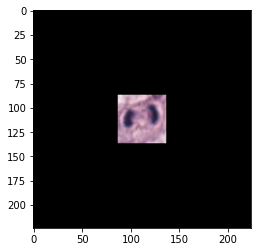

In [13]:
#Here, we load the images from the files we wrote during the patch extraction step.

labels = subclass_annotations['subcl']
imagelist = []

# get the path/directory
folder_dir = "databases"
i = 0
while (i<90):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/' + str(2) + str(i) + str('.png'))
        plt.imshow(temp)
        temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1
i = 0
while (i<155):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/' + str(3) + str(i) + str('.png'))
        plt.imshow(temp)
        temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1
i = 0
while (i<203):
        temp = mpimg.imread('/content/drive/MyDrive/MITOS_WSI_CMC/databases/' + str(5) + str(i) + str('.png'))
        plt.imshow(temp)
        temp = cv2.copyMakeBorder(temp, 87, 87, 87, 87, cv2.BORDER_CONSTANT)
        plt.imshow(temp)
        imagelist.append(temp)
        i = i + 1


In [14]:
#Here, we collapse labels 3,4, and 5 into just label 5.  
labels = np.asarray(labels)
i = 0
while i<len(labels):
    if (np.equal(int(labels[i]),3)):
       labels[i] = 5
    elif (np.equal(int(labels[i]),4)):
       labels[i] = 5
    i = i + 1


In [15]:
#Labels are manually one-hot encoded.
i = 0
ohe_labels = [0] * len(labels)
while (i<len(labels)):
      if (labels[i] == 5):
         ohe_labels[i] = [0, 0, 0, 1]
      elif (labels[i] == 6):
         ohe_labels[i] = [0, 0, 1, 0]
      elif (labels[i] == 7):
         ohe_labels[i] = [0, 1, 0, 0]
      elif (labels[i] == 8):
         ohe_labels[i] = [1, 0, 0, 0]
      i = i + 1

In [16]:
#Labels and images are put into "X" and "y" for the train-test split step.
X = imagelist.copy()
X = np.asarray(X)
y = np.asarray(ohe_labels)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

III. ResNet50 for Classification

In [18]:
#ResNet50 is initialized.

res_model = tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet',input_tensor=None,input_shape=(224,224,3),pooling=None)

res_model.summary()
X_train.shape

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

(313, 224, 224, 3)

In [19]:
for layer in res_model.layers:
  layer.trainable=False

In [31]:
#The sizes of the dense layers were chosen as multiples of the number of classes.
model = models.Sequential()
model.add(res_model)
model.add(layers.Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))


In [32]:
#Initial training
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.01), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test , y_test))


Epoch 1/10
10/10 [==============================] - 108s 11s/step - loss: 12.5350 - accuracy: 0.3642 - val_loss: 1.3310 - val_accuracy: 0.4593
Epoch 2/10
10/10 [==============================] - 77s 8s/step - loss: 1.3166 - accuracy: 0.4537 - val_loss: 1.2941 - val_accuracy: 0.4593
Epoch 3/10
10/10 [==============================] - 76s 8s/step - loss: 1.2871 - accuracy: 0.4537 - val_loss: 1.2695 - val_accuracy: 0.4593
Epoch 4/10
10/10 [==============================] - 77s 8s/step - loss: 1.2646 - accuracy: 0.4537 - val_loss: 1.2519 - val_accuracy: 0.4593
Epoch 5/10
10/10 [==============================] - 74s 8s/step - loss: 1.2521 - accuracy: 0.4537 - val_loss: 1.2393 - val_accuracy: 0.4593
Epoch 6/10
10/10 [==============================] - 74s 8s/step - loss: 1.2382 - accuracy: 0.4537 - val_loss: 1.2290 - val_accuracy: 0.4593
Epoch 7/10
10/10 [==============================] - 76s 8s/step - loss: 1.2318 - accuracy: 0.4537 - val_loss: 1.2231 - val_accuracy: 0.4593
Epoch 8/10
10/10 

In [33]:
#Fine-tuning begins
for layer in res_model.layers[25:]:
   layer.trainable = True
for layer in model.layers[:25]:
   layer.trainable = False

In [34]:


model.compile(optimizer=optimizers.SGD(learning_rate=0.00000001,momentum=0.0,nesterov=False,name='SGD'), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test , y_test))

Epoch 1/50
10/10 [==============================] - 78s 8s/step - loss: 1.2207 - accuracy: 0.4537 - val_loss: 1.2201 - val_accuracy: 0.4593
Epoch 2/50
10/10 [==============================] - 76s 8s/step - loss: 1.2207 - accuracy: 0.4537 - val_loss: 1.2201 - val_accuracy: 0.4593
Epoch 3/50
10/10 [==============================] - 74s 8s/step - loss: 1.2207 - accuracy: 0.4537 - val_loss: 1.2201 - val_accuracy: 0.4593
Epoch 4/50
10/10 [==============================] - 74s 8s/step - loss: 1.2207 - accuracy: 0.4537 - val_loss: 1.2201 - val_accuracy: 0.4593
Epoch 5/50
10/10 [==============================] - 73s 8s/step - loss: 1.2207 - accuracy: 0.4537 - val_loss: 1.2201 - val_accuracy: 0.4593
Epoch 6/50
 7/10 [====================>.........] - ETA: 17s - loss: 1.2097 - accuracy: 0.4598

KeyboardInterrupt: ignored

Ignore the cells below.  They are used to evaluate the model.

In [ ]:
#plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
#plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)


In [ ]:
#from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1) + 5
#y_test=np.argmax(y_test, axis=1)
print(y_pred)
#print(confusion_matrix(y_test, y_pred, labels = [5,6,7,8]))


In [ ]:
labels = pd.DataFrame(labels)
labels.shape
label5 = labels[labels[0]==5]

In [ ]:
label5.shape

In [ ]:
label6 = labels[labels[0]==6]
label6.shape

In [ ]:
label7 = labels[labels[0]==7]
label7.shape

In [ ]:
label8 = labels[labels[0]==8]
label8.shape

In [ ]:
print(y_pred)

In [ ]:
print(y_test)

y_test = np.argmax(y_test, axis = 1) + 5

In [ ]:
print(y_test)

In [ ]:
print(labels)

In [ ]:
print(y_pred)